# Initializing

In [1]:
# https://www.tensorflow.org/datasets/api_docs/python/tfds/load
# https://www.tensorflow.org/datasets/catalog/malaria?hl=pt-br

import cv2 as cv
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Input, BatchNormalization, Layer, Dropout, Resizing, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, Accuracy,TrueNegatives, AUC, Precision, Recall
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
import tensorflow_probability as tfp

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve

2024-10-28 23:42:55.084421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730169775.368265   28418 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730169775.468322   28418 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 23:42:56.049991: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset, dataset_info = tfds.load(
    "malaria",
    with_info=True,
    as_supervised=True,
    shuffle_files=True,
    split=["train"]
    # This dataset in particular has not been splitted previously for us.
    # split=["train", "test"]
)
print(dataset)
# print(dataset_info)

I0000 00:00:1730169789.460411   28418 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2865 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]


In [4]:
def split_dataset(dataset: tf.data.Dataset, train_ratio: float, val_ratio: float, test_ratio: float) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
  size = len(dataset)
  train_dataset = dataset.take(int(size * train_ratio))
  val_dataset = dataset.skip(int(size * train_ratio)).take(int(size * val_ratio))
  test_dataset = dataset.skip(int(size * (train_ratio + val_ratio)))

  return train_dataset, val_dataset, test_dataset


def plot_img(dataset: tf.data.Dataset):
  rows = 4
  cols = 4
  plt.figure(figsize=[5,6])
  for i, (image, label) in enumerate(dataset):
    # print(image[112,112])
    if len(image.shape) <= 3:
      plt.subplot(rows, cols, i+1)
      plt.imshow(image)
      plt.axis("off")
      plt.title(dataset_info.features["label"].int2str(label))
    else:
      for j in range(image.shape[0]):
        if j > rows * cols - 1: break
        plt.subplot(rows, cols, j + 1)
        plt.imshow(image[j])
        plt.axis("off")
        plt.title(dataset_info.features["label"].int2str(label[j].numpy()))
  plt.show()


IMG_SIZE = 224
# passing the label because tf.data.Dataset.map() passes it as well.
@tf.function
def resize_and_normalize(image, label):
  # divinding by 255.0 element wise.
  new_img = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
  return new_img, label

In [5]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset[0], 0.8, 0.1, 0.1)

train_dataset = train_dataset.map(resize_and_normalize).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(resize_and_normalize).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

# It's useless to shuffle and prefetch the test_dataset because it's not used for training.
# It's still necessary to batch it since the model expects the inputs to be in batches though.
test_dataset = test_dataset.map(resize_and_normalize).batch(1)

# Familiarizing

In [ ]:
# from_logits = False -> assumes the input values are between 0 and 1
bce = BinaryCrossentropy(from_logits = False)
test_true = tf.constant([1, 0, 0, 1])
# test_pred = tf.constant([1, 0, 0, 1])
test_pred = tf.constant([1, 0, 1, 0])

# The closer test_pred is to test_true, the lower the output of BCE.
# If they're equal, the value is a very small value (closes to zero, like 1.192093e-07)
bce(test_true, test_pred)

In [ ]:
# It's list
len(dataset), dataset

In [ ]:
for data in dataset[0].take(1):
  # 'data' is a tuple! The first parameter is the image, the second is the label in numeric format (0 or 1 for this case)
  print(data)

In [ ]:
plt.figure(figsize=[20,5])

# Taking N number of elements (images) from the dataset.
n = 6
for i, data in enumerate(dataset[0].take(n)):
  plt.subplot(100 + n * 10 + (i+1))
  plt.imshow(data[0])

plt.show()

In [ ]:
testset = tf.data.Dataset.range(10)
testset = testset.skip(5)
print(list(testset.as_numpy_iterator()))

In [ ]:
testset = tf.data.Dataset.range(10)
train, val, test = split_dataset(testset, 0.6, 0.2, 0.2)

print(list(train.as_numpy_iterator()))
print(list(val.as_numpy_iterator()))
print(list(test.as_numpy_iterator()))

print("-"*30)
train, val, test = split_dataset(testset, 0.6, 0, 0.2)

print(list(train.as_numpy_iterator()))
print(list(val.as_numpy_iterator()))
print(list(test.as_numpy_iterator()))

In [ ]:
# the output changes based on if you passed through resize_and_normalize or not.
# WARNING: the dataset must NOT be inside batches.
# NOTE: it actually may be inside batches now
plot_img(train_dataset.take(1))

# Sequential API

In [ ]:
# Conv2D -> Extracts features.
# MaxPool2D -> Extracts the most important features using max() in the elements of a cell of size pool_size * pool_size.
# Using relu as activation instead of sigmoid may increase the performance (computational cost) while training.
# BatchNormalization -> When inputs to a layer are normalized, it becomes easier for the model to learn the important features in a more stable manner.

model = tf.keras.Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(filters=6, kernel_size=5, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    # In this model, the number of filters (6 and then 16) represents the number of feature maps the convolutional
    # layers will learn. By starting with fewer filters (6) in the first layer, we're keeping the initial computation
    # lower and focusing on learning simpler, broad features from the input image, such as edges and basic shapes.
    # As we go deeper in the network, increasing the filters to 16 allows the model to learn more complex features
    # since the image resolution has been reduced by the pooling layers, and there’s less spatial information to process.
    Conv2D(filters=16, kernel_size=5, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),

    Dense(100, activation="relu"),
    BatchNormalization(),
    Dense(10, activation="relu"),
    BatchNormalization(),
    # 1 because even if it's 'uninfected' or 'parasitized', we just want 0 OR 1 as output.
    Dense(1, activation="sigmoid")
])

model.summary()

In [ ]:
model.compile(
    optimizer = Adam(learning_rate=0.1),
    loss = BinaryCrossentropy(),
    metrics = ["accuracy"]
)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

In [ ]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train dataset loss", "validation dataset loss"])
plt.title("Model Loss")
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accurary")
plt.legend(["train dataset accuracy", "validation dataset accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
model.evaluate(test_dataset.take(1))

In [ ]:
model.predict(test_dataset.take(1))

In [ ]:
def parasited_or_not(x):
  if x < 0.5:
    return "P"
  else:
    return "U"

width = 3
height = 3

plt.figure()
for i, (image, label) in enumerate(test_dataset.take(width*height)):
  plt.subplot(width, height, i+1)
  plt.imshow(image[0])
  plt.axis("off")
  pred = model.predict(image)[0][0]
  plt.title(str(parasited_or_not(label.numpy()[0])) + ":" + str(parasited_or_not(pred)))

plt.show()

In [ ]:
model.save("mymodel.keras")
model.save("mymodel.h5")

# Functional API

In [ ]:
input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name = "Input_Image")

# You could put all these togheter inside tf.keras.Sequential and feed it to Flatten()(sequential)
x = Conv2D(filters=6, kernel_size=5, strides=1, padding="valid", activation="relu")(input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=5, strides=1, padding="valid", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)
output = Dense(1, activation="sigmoid")(x)

fun_model = Model(input, output, name="Linet_Model")
fun_model.summary()

In [11]:
fun_model.compile(
    optimizer = Adam(learning_rate=0.1),
    loss = BinaryCrossentropy(),
    metrics = ["accuracy"]
)

In [ ]:
# with tf.device("GPU:0"):
history = fun_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

In [ ]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train dataset loss", "validation dataset loss"])
plt.title("Model Loss")
plt.show()

# Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters=8, kernel_size=3, k_strides=1, padding="valid", activation="relu", pool_size=2, pool_strides=2):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size=kernel_size, strides=k_strides, padding=padding, activation=activation)
    self.batchn_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*pool_strides)
    
    # self.conv_2 = Conv2D(filters = math.ceil(filters*2.5), kernel_size=kernel_size, strides=k_strides, padding=padding, activation=activation)
    self.conv_2 = Conv2D(filters = filters*2, kernel_size=kernel_size, strides=k_strides, padding=padding, activation=activation)
    self.batchn_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*pool_strides)

  # No, it's NOT the dunder call (__call__).
  def call(self, x_in, training = None):
    x = self.conv_1(x_in)
    x = self.batchn_1(x)
    x = self.pool_1(x)
    
    x = self.conv_2(x)
    x = self.batchn_2(x)
    x_out = self.pool_2(x)
    
    return x_out

class FeatureClassification(Layer):
  def __init__(self, units = 100, activation = "relu"):
    super(FeatureClassification, self).__init__()
    self.dense_1 = Dense(units = units, activation = activation)
    self.batchn_1 = BatchNormalization()
    # self.dense_2 = Dense(units = math.ceil(units / 10), activation = activation)
    self.dense_2 = Dense(units = 10, activation = activation)
    self.batchn_2 = BatchNormalization()
    self.dense_out = Dense(units = 1, activation = "sigmoid")

  def call(self, x_in, training = None):
    x = self.dense_1(x_in)
    x = self.batchn_1(x)
    x = self.dense_2(x)
    x = self.batchn_2(x)
    x_out = self.dense_out(x)
    return x_out

class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()
    # self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.feat_ext = FeatureExtractor()
    self.flatten = Flatten()
    self.feat_classf = FeatureClassification()
    
  # WARNING: apparently, if you miss this 'training' parameter here,
  # your model doesnt perform as it should.
  def call(self, x, training = None):
    x = self.feat_ext(x)
    x = self.flatten(x)
    x = self.feat_classf(x)
    return x

subc_model = LenetModel()
subc_model(tf.zeros([1,224,224,3]))
subc_model.summary()

subc_model.compile(
    optimizer = Adam(learning_rate=0.1),
    loss = BinaryCrossentropy(),
    metrics = ["accuracy"]
)

In [ ]:
history = subc_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

In [ ]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train dataset loss", "validation dataset loss"])
plt.title("Model Loss")
plt.show()

# Custom Layers

In [15]:
class CustomDenseLayer(Layer):
    def __init__(self, units, activation):
        super(CustomDenseLayer, self).__init__()
        """
        units => specifies the number of neurons (or output units) in the layer. 
        It defines the size of the output vector produced by the layer when it 
        processes the input features.
        """
        self.c_units = units
        self.c_activation = activation

    def build(self, input_features_shape):
        # self.add_weight(...) comes from the superclass.
        
        # input_features (passed to call()) will have a shape of:
        # - (batch, cols)
        # so we need this c_weights to have shape of: 
        # - (cols, c_units)
        self.c_weight = self.add_weight(shape = (input_features_shape[-1], self.c_units), initializer = "random_normal", trainable = True)
        self.c_bias  = self.add_weight(shape = (self.c_units,), initializer = "zeros", trainable = True)
    
    def call(self, input_features):
        pre_output = tf.matmul(input_features, self.c_weight) + self.c_bias

        if self.c_activation == "relu":
            return tf.nn.relu(pre_output)
        
        if self.c_activation == "sigmoid":
            return tf.math.sigmoid(pre_output)
        
        return pre_output

In [ ]:
custom_layer_model = tf.keras.Sequential([
    Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    
    Conv2D(filters=6, kernel_size=5, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=5, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Flatten(),

    CustomDenseLayer(100, activation="relu"),
    BatchNormalization(),
    CustomDenseLayer(10, activation="relu"),
    BatchNormalization(),
    CustomDenseLayer(1, activation="sigmoid")
])

custom_layer_model.summary()
custom_layer_model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss = BinaryCrossentropy(from_logits=False),
    metrics = [BinaryAccuracy()]
)

In [ ]:
history = custom_layer_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

In [ ]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train dataset loss", "validation dataset loss"])
plt.title("Model Loss")
plt.show()

# Receiver Operating Characteristics (ROC)

In [35]:
model = tf.keras.Sequential(
    [
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),
        Conv2D(
            filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"
        ),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),
        Flatten(),
        Dense(100, activation="relu"),
        BatchNormalization(),
        Dense(10, activation="relu"),
        BatchNormalization(),
        Dense(1, activation="sigmoid"),
    ]
)

metrics = [
    # Accuracy(name="accuracy"),
    BinaryAccuracy(name="accuracy"),
    FalsePositives(name="fp"),
    FalseNegatives(name="fn"),
    TruePositives(name="tp"),
    TrueNegatives(name="tn"),
    AUC(name="auc"), # Area Under Curve
    Precision(name="precision"),
    Recall(name="recall"),
]

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryCrossentropy(from_logits=False),
    metrics=metrics,
)

In [ ]:
# This here would have all features, but it's a really, REALLY bad idea to do it because it loads all features into memory at once.
# Use this instead => x_test = test_dataset.map(lambda image, label : image)
# inp = []
labels = []

# Don't use inp[] if your GPU doesn't have enough memory.
with tf.device("/CPU:0"):
    for image, label in test_dataset.as_numpy_iterator():
        labels.append(label)
        # inp.append(image)

# print(np.array(inp).shape)
# print(np.array(inp)[:, 0, ...].shape)

print(np.array(labels).shape)
# [:, 0] -> used to remove unnecessary ranks (dimensions). You could probably tf.squeeze instead.
print(np.array(labels)[:, 0].shape)
print(np.array(labels)[:, 0])

labels = np.array(labels)[:, 0]


In [ ]:
# history = model.fit(train_dataset, validation_ data=val_dataset, epochs=5, verbose=1)
history = model.fit(train_dataset, epochs=15, verbose=1)

In [ ]:
model.evaluate(test_dataset, verbose=1)

In [ ]:
# Extracting only the features
x_test = test_dataset.map(lambda x, y: x)
# predicted -> contains the probability of being or not parasited.
predicted = model.predict(x_test)

In [ ]:
print(predicted.shape)
print(predicted[:, 0])

In [ ]:
epoch_threshold = 0.5

# values above threshold are uninfected and below or equal are parasitized.
# confusion_matrix(...) is capable of finding FP and FN as well because it compares the results
# of predicted < threshold with the label values.
cm = confusion_matrix(labels, predicted < epoch_threshold)
print(cm)

plt.figure(figsize=[8,8])
sns.heatmap(cm, annot=True, fmt="d")
plt.title(f"Confusion Matrix - {epoch_threshold}")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
print([len(fp), len(tp), len(thresholds)])

plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

# Skiping elements because we cannot read all thresholds at the same time, it's a mess.
for i in range(0, len(thresholds), 100):
    plt.text(fp[i], tp[i], thresholds[i])

plt.show()

# Callbacks

In [10]:
class PrintLossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print(f"\nEpoch {epoch+1} :: loss {logs['loss']}")
        
    def on_batch_end(self, batch, logs):
        print(f"\nBatch {batch+1} :: loss {logs}")

In [7]:
model = tf.keras.Sequential(
    [
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),
        Conv2D(
            filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"
        ),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),
        Flatten(),
        Dense(100, activation="relu"),
        BatchNormalization(),
        Dense(10, activation="relu"),
        BatchNormalization(),
        Dense(1, activation="sigmoid"),
    ]
)

metrics = [
    BinaryAccuracy(name="accuracy"),
    FalsePositives(name="fp"),
    FalseNegatives(name="fn"),
    TruePositives(name="tp"),
    TrueNegatives(name="tn"),
    AUC(name="auc"), # Area Under Curve
    Precision(name="precision"),
    Recall(name="recall"),
]

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryCrossentropy(from_logits=False),
    # metrics=metrics,
)

In [8]:
csv_logger = CSVLogger("logs.csv", separator=",", append=False)
"""
monitor -> name of the metric to monitor.
patience -> number of epochs without improvment which can be tolerated.
mode -> min (decreasing metric, like loss), max (increasing metric, like accuracy) and auto (inferred automatically)
"""
early_stopping = EarlyStopping(
    monitor="loss", patience=1, verbose=1, mode="auto", restore_best_weights=False
)


def scheduler(epoch, lr):
    epoch_threshold = 2
    if epoch < epoch_threshold:
        return lr
    else:
        # Exponentially decreasing the learning rate.
        return float(
            lr * tf.math.exp(-0.1)
        )  # casting due to tensorflow not recognizing the output tf.Tensor as float


learning_rate_scheduler = LearningRateScheduler(scheduler, verbose=1)

model_checkpoint = ModelCheckpoint(
    filepath="checkpoint.keras",
    monitor="loss",
    verbose=1,
    save_best_only=True,  # filepath must end in .keras if True
    save_weights_only=False,  # filepath must end in .hd5 if True
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.01,  # Factor by which the learning rate will be reduced. new_lr = lr * factor.
    patience=3,  # Number of epochs with no improvement after which learning rate will be reduced.
    verbose=1,
    mode="auto",
    min_delta=0.0001,  # Threshold for measuring the new optimum, to only focus on significant changes.
    cooldown=0,  # Number of epochs to wait before resuming normal operation after the learning rate has been reduced.
    min_lr=0.0,  # Lower bound on the learning rate.
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=1,
    # callbacks=[PrintLossCallback(), csv_logger],
    # callbacks=[csv_logger],
    # callbacks=[early_stopping],
    # callbacks=[learning_rate_scheduler],
    # callbacks=[model_checkpoint],
    callbacks=[reduce_lr_on_plateau],
)

# Dropout and Regularization

In [9]:
dropout_rate = 0.2
regularization_rate = 0.01

model = tf.keras.Sequential(
    [
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Conv2D(
            filters=6,
            kernel_size=3,
            strides=1,
            padding="valid",
            activation="relu",
            kernel_regularizer=L2(regularization_rate),
        ),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),
        # The purpose of a Dropout layer is to help prevent overfitting in neural networks. 
        # It does this by randomly setting a fraction of the input units (neurons) to zero 
        # during each training iteration.
        Dropout(rate=dropout_rate),
        Conv2D(
            filters=16,
            kernel_size=3,
            strides=1,
            padding="valid",
            activation="relu",
            kernel_regularizer=L2(regularization_rate),
        ),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),
        Flatten(),
        Dense(
            100,
            activation="relu",
            kernel_regularizer=L2(regularization_rate),
        ),
        BatchNormalization(),
        Dropout(rate=dropout_rate),
        Dense(
            10,
            activation="relu",
            kernel_regularizer=L2(regularization_rate),
        ),
        BatchNormalization(),
        Dense(1, activation="sigmoid"),
    ]
)

metrics = [
    BinaryAccuracy(name="accuracy"),
    FalsePositives(name="fp"),
    FalseNegatives(name="fn"),
    TruePositives(name="tp"),
    TrueNegatives(name="tn"),
    AUC(name="auc"),  # Area Under Curve
    Precision(name="precision"),
    Recall(name="recall"),
]

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryCrossentropy(from_logits=False),
    metrics=metrics,
)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, verbose=1)

In [45]:
CONFIGURATION = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 5,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
}

IM_SIZE = CONFIGURATION["IM_SIZE"]
DROPOUT_RATE = CONFIGURATION["DROPOUT_RATE"]
REGULARIZATION_RATE = CONFIGURATION["REGULARIZATION_RATE"]
N_FILTERS = CONFIGURATION["N_FILTERS"]
KERNEL_SIZE = CONFIGURATION["KERNEL_SIZE"]
POOL_SIZE = CONFIGURATION["POOL_SIZE"]
N_STRIDES = CONFIGURATION["N_STRIDES"]

lenet_model = tf.keras.Sequential(
    [
        Input(shape=(IM_SIZE, IM_SIZE, 3)),
        Conv2D(
            filters=N_FILTERS,
            kernel_size=KERNEL_SIZE,
            strides=N_STRIDES,
            padding="valid",
            activation="relu",
            kernel_regularizer=L2(REGULARIZATION_RATE),
        ),
        BatchNormalization(),
        MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES * 2),
        Dropout(rate=DROPOUT_RATE),
        Conv2D(
            filters=N_FILTERS * 2 + 4,
            kernel_size=KERNEL_SIZE,
            strides=N_STRIDES,
            padding="valid",
            activation="relu",
            kernel_regularizer=L2(REGULARIZATION_RATE),
        ),
        BatchNormalization(),
        MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES * 2),
        Flatten(),
        Dense(
            CONFIGURATION["N_DENSE_1"],
            activation="relu",
            kernel_regularizer=L2(REGULARIZATION_RATE),
        ),
        BatchNormalization(),
        Dropout(rate=DROPOUT_RATE),
        Dense(
            CONFIGURATION["N_DENSE_2"],
            activation="relu",
            kernel_regularizer=L2(REGULARIZATION_RATE),
        ),
        BatchNormalization(),
        Dense(1, activation="sigmoid"),
    ]
)

metrics = [
    BinaryAccuracy(name="accuracy"),
    FalsePositives(name="fp"),
    FalseNegatives(name="fn"),
    TruePositives(name="tp"),
    TrueNegatives(name="tn"),
    AUC(name="auc"),  # Area Under Curve
    Precision(name="precision"),
    Recall(name="recall"),
]

lenet_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryCrossentropy(from_logits=False),
    metrics=metrics,
)

In [ ]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)
x_test = test_dataset.map(lambda x, y: x)
predicted = lenet_model.predict(x_test)

# Data Augmentation

In [ ]:
def show_augument(original, augmented):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(original)
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.imshow(augmented)
    plt.show()

def augment_img(original):
    image = tf.image.flip_left_right(original)
    image = tf.image.flip_up_down(image)
    # image = tf.image.rot90(image)
    return image

# Well, iterators really are something.
original, label = next(iter(train_dataset))
original = original[0, ...] # extracting one from 32 batch size
print(original.shape)

augmented = augment_img(original)
show_augument(original, augmented)

# This here would lead to an error because x is actually a batch(32) of images,
# so you would need to modify the method to individually augment each image.
# test_dataset2 = test_dataset.map(lambda x, y : augment_img(x), y)

In [14]:
augment_layer = tf.keras.Sequential([
    RandomFlip(mode="horizontal", seed=None),
    # If 2Pi is 100%, 0.25 is 25% anticlockwise. -0.25 would be clockwise.
    # Pi = 180
    # (lower_bound, upper_bound)
    RandomRotation((0.25, 0.2501))
])

# WARNING: if you use this layer, you cannot use train_dataset.batch(?>1) 
# because the images are still with different sizes at this point.
#
# Equivalent to (but less flexible):
# -> tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
resize_rescale_layer = tf.keras.Sequential([
    Resizing(IMG_SIZE, IMG_SIZE),
    Rescaling(1.0/255.0)
])

In [23]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset[0], 0.8, 0.1, 0.1)

# WARNING: if you use this layer, you cannot use train_dataset.batch(?>1) 
# because the images are still with different sizes at this point.
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(1).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(1).prefetch(tf.data.AUTOTUNE)

# It's useless to shuffle and prefetch the test_dataset because it's not used for training.
# It's still necessary to batch it since the model expects the inputs to be in batches though.
test_dataset = test_dataset.batch(1)

In [ ]:
# This made the training even slower, I still prefer to save the augmentation in the hardware.
class CustomAugmentationLayer(Layer):
    def __init__(
        self,
    ):
        super().__init__()

    def call(self, image):
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
        
        seed = (
            tf.random.uniform([], maxval=10000, dtype=tf.int32),
            tf.random.uniform([], maxval=10000, dtype=tf.int32),
        )
        # stateless -> deterministic with seed
        image = tf.image.stateless_random_flip_left_right(image, seed=seed)
        # image = tf.image.stateless_random_flip_up_down(image)
        
        image = tf.image.rot90(
            image, (tf.random.uniform(shape=(), minval=0, maxval=2, dtype=tf.int32))
        )
        
        return image

    def compute_output_shape(self, input_shape):
        return (input_shape[0], IMG_SIZE, IMG_SIZE, input_shape[3])


test = CustomAugmentationLayer()(
    tf.random.uniform(shape=(1, 150, 200, 3), minval=0, maxval=9)
)
test.shape
# plt.imshow(test[0, ...])

In [53]:
model = tf.keras.Sequential(
    [
        # `None` because now we don't now the shape of the images before passing
        # it to the model.
        Input(shape=(None, None, 3)),
        
        # This is possible because tf.keras.Sequential is just another Layer.
        # resize_rescale_layer,
        # augment_layer,
        CustomAugmentationLayer(),
        
        Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),
        Conv2D(
            filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"
        ),
        BatchNormalization(),
        MaxPool2D(pool_size=2, strides=2),
        Flatten(),
        Dense(100, activation="relu"),
        BatchNormalization(),
        Dense(10, activation="relu"),
        BatchNormalization(),
        Dense(1, activation="sigmoid"),
    ]
)

metrics = [
    # Accuracy(name="accuracy"),
    BinaryAccuracy(name="accuracy"),
    FalsePositives(name="fp"),
    FalseNegatives(name="fn"),
    TruePositives(name="tp"),
    TrueNegatives(name="tn"),
    AUC(name="auc"), # Area Under Curve
    Precision(name="precision"),
    Recall(name="recall"),
]

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryCrossentropy(from_logits=False),
    # metrics=metrics,
    # Use run_eagerly=True for debbuging purposes only, because it also
    # causes performance losses comapred to graph mode.
    # run_eagerly=True,
)

In [ ]:
history = model.fit(train_dataset, validation_data=None, epochs=1, verbose=1)

In [27]:
def save_image(image):
    # not necessary (depends on WHICH `train_dataset` you're using).
    # image = np.clip(image * 255, 0, 255)
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
    cv.imwrite("cell.jpg", image)


def save_image_v2(image):
    # image = tf.clip_by_value(image * 255, 0, 255)
    # image = tf.cast(image, tf.uint8)
    encoded_image = tf.image.encode_jpeg(image)
    tf.io.write_file("cell2.jpg", encoded_image)


image, label = next(iter(test_dataset))
image = image[0, ...]  # remember, it's batched

save_image(image.numpy())
save_image_v2(image)
# show_augument(image, image)

In [ ]:
image = cv.imread("cell.jpg")[:, :, ::-1]
# show_augument(image, image)
model.predict(tf.expand_dims(image, axis=0))

## Mixup Augmentation 

In [6]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset[0], 0.8, 0.1, 0.1)

val_dataset = (
    val_dataset.map(resize_and_normalize)
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = test_dataset.map(resize_and_normalize)

In [7]:
def mixup_fun(dataset_1, dataset_2):
    (image_1, label_1), (image_2, label_2) = dataset_1, dataset_2
    _lambda = tfp.distributions.Beta(0.5, 0.5)
    _lambda = _lambda.sample(1)[0]

    label_1 = tf.cast(label_1, dtype=tf.float32)
    label_2 = tf.cast(label_2, dtype=tf.float32)

    image = _lambda * image_1 + (1 - _lambda) * image_2
    label = _lambda * label_1 + (1 - _lambda) * label_2

    return image, label

In [42]:
train_dataset_1 = train_dataset.shuffle(
    buffer_size=8, reshuffle_each_iteration=True
).map(resize_and_normalize)
train_dataset_2 = train_dataset.shuffle(
    buffer_size=8, reshuffle_each_iteration=True
).map(resize_and_normalize)

# create a new tf.data.Dataset containing a pair of (image_1, label_1), (image_2, label_2)
mixup_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

train_mixup_dataset = (
    mixup_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .map(mixup_fun)
    # .batch(32) # not a good idea to use batch(32) when using next(iter(`dataset`))
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)

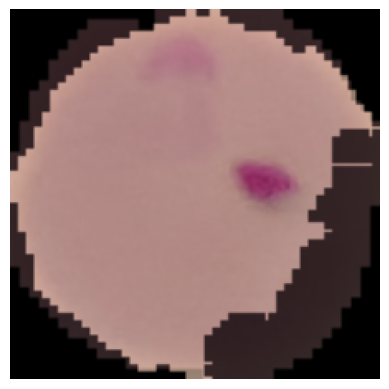

In [47]:
image, label = next(iter(train_mixup_dataset))
image = image[0, ...]

plt.figure()
plt.axis("off")
plt.imshow(image)
plt.show()